# 웹 크롤링 방법

-동적페이지 : URL의 변경 없이 페이지의 내용이 변경 - json

-정적페이지 : URL이 변경 되면서 페이지의 내용이 변경 - html

In [1]:
import pandas as pd
import requests

## 네이버 주가 데이터수집
- 동적 페이지 : JSON

- 모바일 페이지로 수집

In [5]:
# 1. 웹서비스 분석 : 개발자 도구 : URL

In [15]:
url = f"https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}"

In [4]:
# 2. 서버에 데이터 요청 : request(URL) > response(JSON)

In [16]:
response = requests.get(url)
response

<Response [200]>

In [17]:
response.text[:200]

'[{"localTradedAt":"2022-02-21","closePrice":"2,728.98","compareToPreviousClosePrice":"-15.54","compareToPreviousPrice":{"code":"5","text":"하락","name":"FALLING"},"fluctuationsRatio":"-0.57","openPrice"'

In [ ]:
# 3. JSON(str) > parsing > dict, list > DataFrame

In [18]:
datas = response.json()
type(datas)

list

In [19]:
datas[:2]

[{'localTradedAt': '2022-02-21',
  'closePrice': '2,728.98',
  'compareToPreviousClosePrice': '-15.54',
  'compareToPreviousPrice': {'code': '5', 'text': '하락', 'name': 'FALLING'},
  'fluctuationsRatio': '-0.57',
  'openPrice': '2,706.65',
  'highPrice': '2,734.53',
  'lowPrice': '2,694.90'},
 {'localTradedAt': '2022-02-18',
  'closePrice': '2,744.52',
  'compareToPreviousClosePrice': '0.43',
  'compareToPreviousPrice': {'code': '2', 'text': '상승', 'name': 'RISING'},
  'fluctuationsRatio': '0.02',
  'openPrice': '2,714.52',
  'highPrice': '2,747.08',
  'lowPrice': '2,711.88'}]

In [21]:
colums = ['localTradedAt', 'closePrice']
kospi_df = pd.DataFrame(datas)[colums]
kospi_df.head()

,localTradedAt,closePrice
0,2022-02-21,"2,728.98"
1,2022-02-18,"2,744.52"
2,2022-02-17,"2,744.09"
3,2022-02-16,"2,729.68"
4,2022-02-15,"2,676.54"


In [22]:
# 4. 함수로 만들기

In [26]:
def stock_price(code = "KOSPI", page_size = 20, page = 1) :
    """
    params : code(KOSPI or KOSDAQ)
    """
    url = f"https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}"
    response = requests.get(url)
    datas = response.json()
    return pd.DataFrame(datas)[['localTradedAt', 'closePrice']]

df = stock_price("KOSDAQ")
df.head(2)

,localTradedAt,closePrice
0,2022-02-21,879.92
1,2022-02-18,881.71


In [27]:
# 5. 원달러 환율 데이터 수집

In [33]:
def exchange_rate(code = 'FX_USDKRW', page = 1, page_size = 20) :
    url = f"https://api.stock.naver.com/marketindex/exchange/{code}/prices?page={page}&pageSize={page_size}"
    response = requests.get(url)
    datas = response.json()
    return pd.DataFrame(datas)[['localTradedAt', 'closePrice']]

usd = exchange_rate()
usd.head()

,localTradedAt,closePrice
0,2022-02-21,"1,195.00"
1,2022-02-18,"1,195.50"
2,2022-02-17,"1,197.50"
3,2022-02-16,"1,198.00"
4,2022-02-15,"1,197.50"


In [34]:
# 시각화 및 상관관계 분석

In [35]:
%config InlineBackend.figure_formats = {'png','retina'}

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
#데이터 수집 : kospi, kosdaq, usd
kospi = stock_price()
kosdaq = stock_price('KOSDAQ')
usd = exchange_rate()

In [50]:
#데이터 전처리 : str > float
kospi.dtypes

localTradedAt    object
closePrice       object
dtype: object

In [56]:
kospi["closePrice"]= kospi["closePrice"].apply(lambda data : float(data.replace(",","")))
kosdaq["closePrice"]= kosdaq["closePrice"].apply(lambda data : float(data.replace(",","")))
usd["closePrice"]= usd["closePrice"].apply(lambda data : float(data.replace(",","")))

In [ ]:
# lambda : 일회성 함수, lambda params:return

In [59]:
def plus(num1, num2) :
    return num1 + num2
def minus(num1, num2) :
    return num1 - num2
def calc(func, num1, num2) :
    return func(num1, num2)

calc(plus, 1, 2)

3

In [60]:
calc(lambda num1, num2 : num1+num2,1,2)

3

In [ ]:
# apply(func) : 모든 데이터에 func을 적용시킨 결과 출력

In [78]:
df = kospi.copy()
df = df.rename(columns = {"localTradedAt" : 'date', 'closePrice': 'kospi'})
df['kosdaq'] = kosdaq['closePrice']
df['usd'] = usd['closePrice']
df.head()

,date,kospi,kosdaq,usd
0,2022-02-21,2733.81,880.98,1194.4
1,2022-02-18,2744.52,881.71,1195.5
2,2022-02-17,2744.09,874.22,1197.5
3,2022-02-16,2729.68,878.15,1198.0
4,2022-02-15,2676.54,839.92,1197.5


In [ ]:
# 그래프그리기

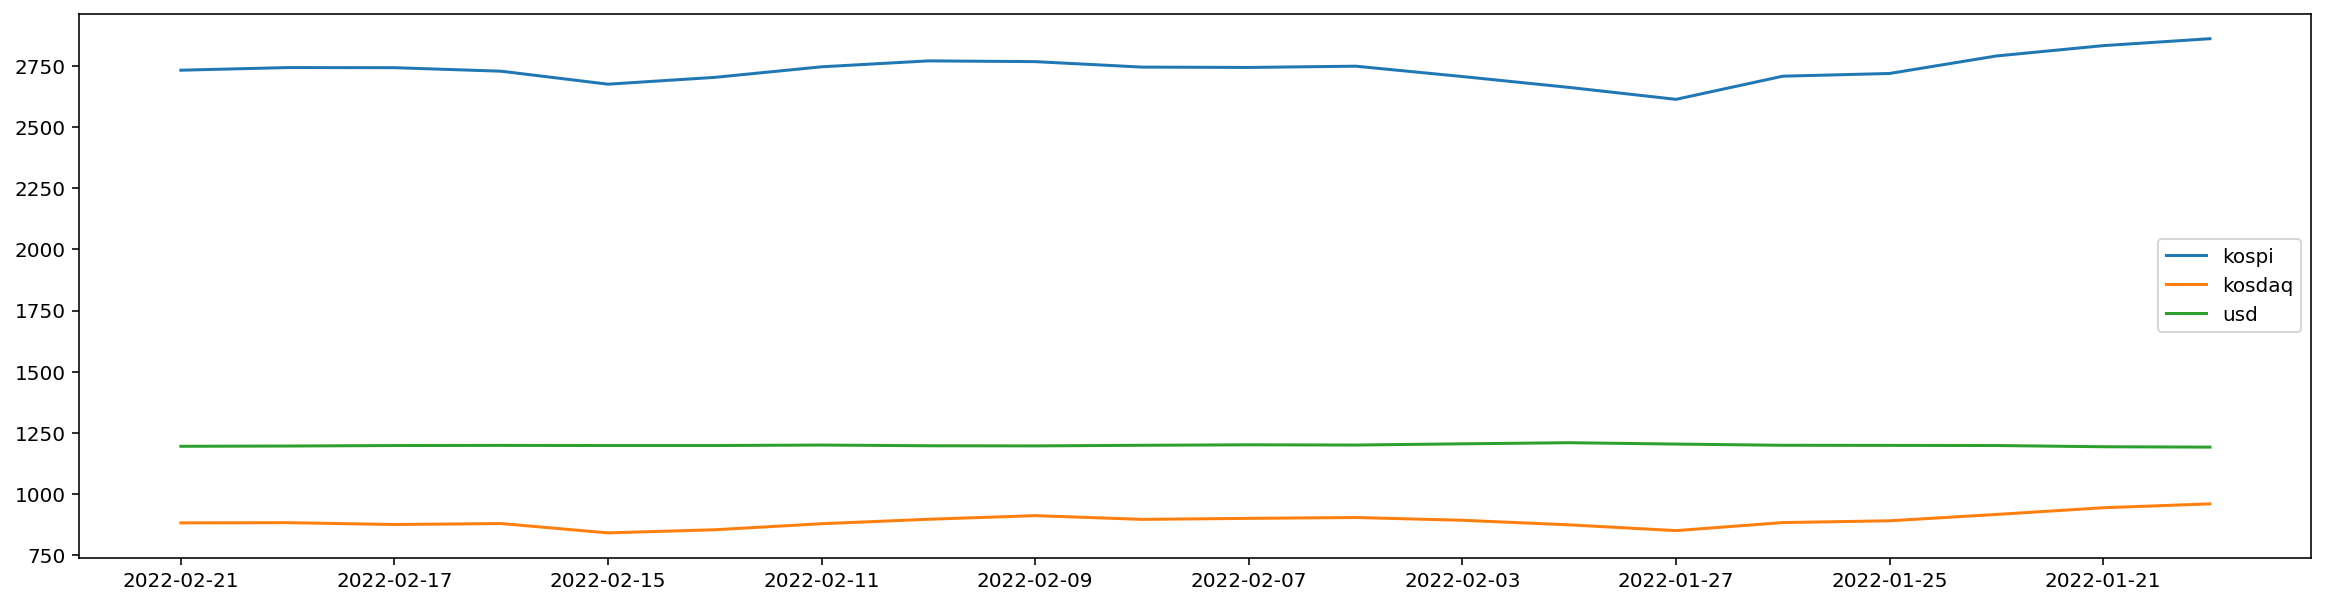

In [81]:
plt.figure(figsize=(20,5))
# plt.plot(df['date'], df['kospi'], label = 'kospi')
# plt.plot(df['date'], df['kosdaq'], label = 'kosdaq')
# plt.plot(df['date'], df['usd'], label = 'usd')

for column in df.columns[1:] :
    plt.plot(df['date'], df[column], label = column)
    
plt.xticks(df['date'][::2])
plt.legend()
plt.show()

In [82]:
#데이터 스케일링 : min max scale
# z = x-min(x) / (max(x) - min(x))   :   0(최소값) <= z <= 1(최댓값)

In [83]:
from sklearn.preprocessing import minmax_scale

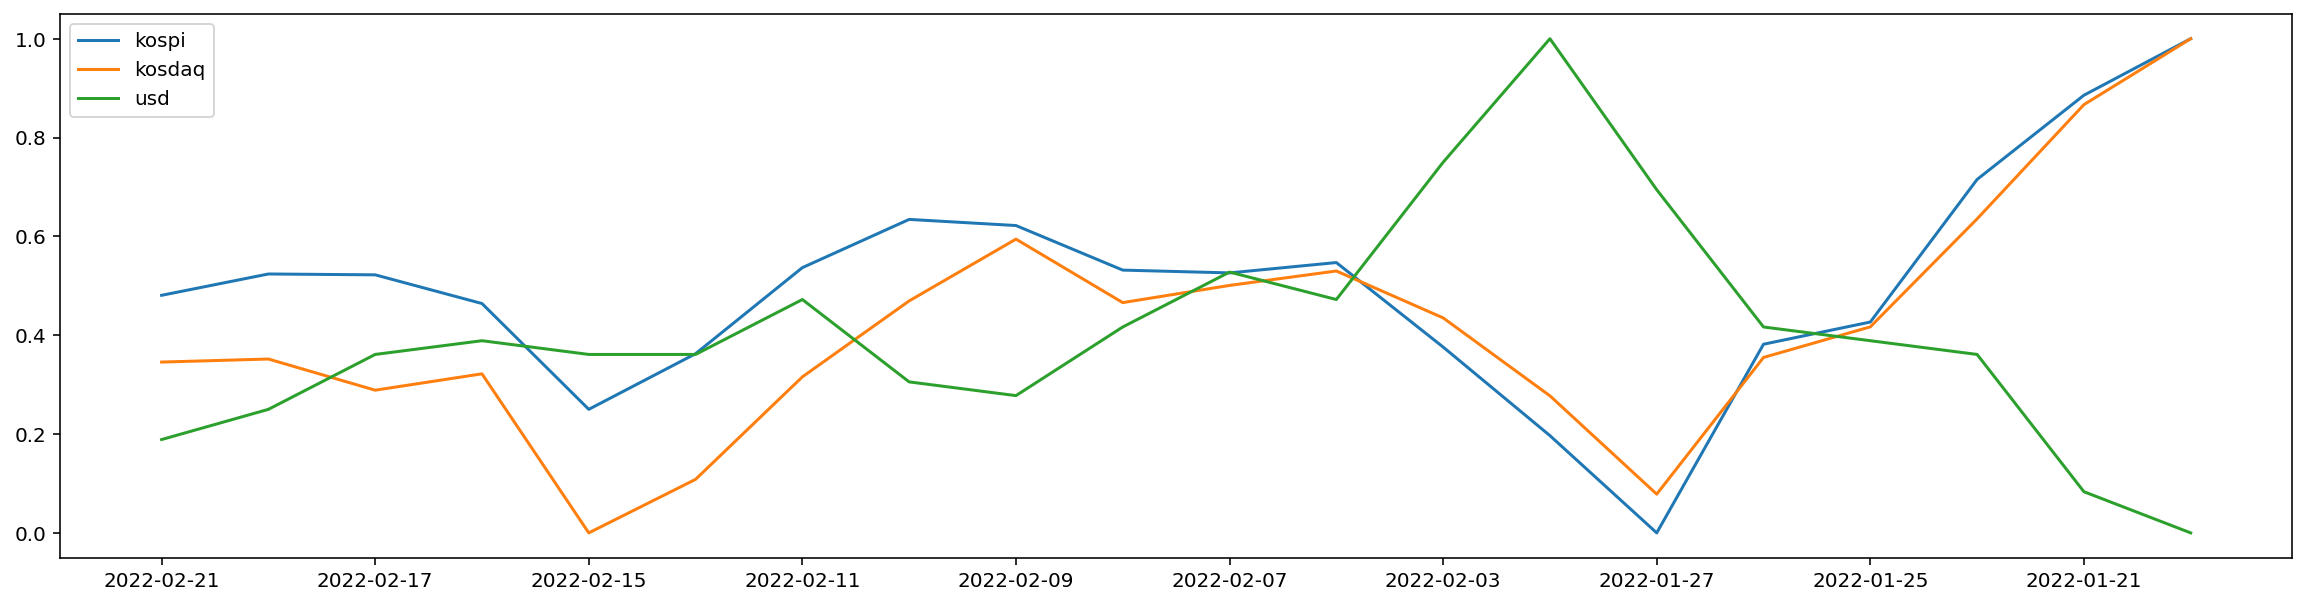

In [84]:
plt.figure(figsize=(20,5))

for column in df.columns[1:] :
    plt.plot(df['date'], minmax_scale(df[column]), label = column)
    
plt.xticks(df['date'][::2])
plt.legend()
plt.show()

#상관관계분석

#상관계수 : 
0과 가까울수록 두 데이터는 관계가 없음

1과 가까울수록 두데이터는 강한 양의 상관 관계를 갖는다.

-1과 가까울수록 두 데이터는 강한 음의 상관관계

#kospi-kosdaq : 강한 양의 상관관계(kospi가 올라갈때 kosdaq 상승)

#kospi-usd : 강한 음의 상관관계(kospi가 떨어질때 usd상승)

In [86]:
df[df.columns[1:]].corr()

,kospi,kosdaq,usd
kospi,1.000000,0.893268,-0.744822
kosdaq,0.893268,1.000000,-0.505525
usd,-0.744822,-0.505525,1.000000
